# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

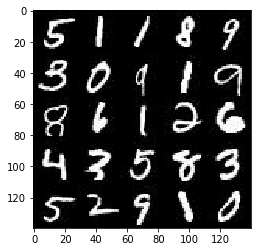

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

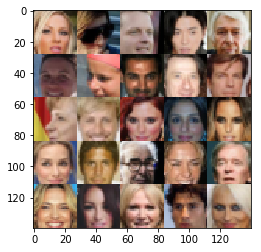

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate',shape=())
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.15
        x1 = tf.layers.conv2d(images, 64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x2, training=is_train)
        x3 = tf.maximum(alpha * x2, x2)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim,5,strides=2,padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sampels, losses = [],[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                #batch_images = batch_images * 2
                steps += 1
                
                # Real image input for discriminator
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2],data_shape[3])
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count), 
                           "Discriminator Loss: {:4f}...".format(train_loss_d),
                           "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after trainig
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3],data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.541444... Generator Loss: 5.6528
Epoch 1/2... Discriminator Loss: 2.237489... Generator Loss: 0.3969
Epoch 1/2... Discriminator Loss: 0.493843... Generator Loss: 9.3490
Epoch 1/2... Discriminator Loss: 1.021264... Generator Loss: 2.2286
Epoch 1/2... Discriminator Loss: 0.791553... Generator Loss: 2.8062
Epoch 1/2... Discriminator Loss: 1.189540... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 0.993279... Generator Loss: 1.7150
Epoch 1/2... Discriminator Loss: 1.307506... Generator Loss: 1.9528
Epoch 1/2... Discriminator Loss: 1.012537... Generator Loss: 1.0018
Epoch 1/2... Discriminator Loss: 1.046943... Generator Loss: 1.5195


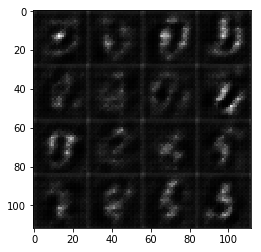

Epoch 1/2... Discriminator Loss: 1.177198... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 1.357669... Generator Loss: 1.7781
Epoch 1/2... Discriminator Loss: 1.155181... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.081793... Generator Loss: 0.9809
Epoch 1/2... Discriminator Loss: 1.079796... Generator Loss: 1.0103
Epoch 1/2... Discriminator Loss: 1.128937... Generator Loss: 2.0763
Epoch 1/2... Discriminator Loss: 1.122619... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 1.199430... Generator Loss: 1.8689
Epoch 1/2... Discriminator Loss: 1.151302... Generator Loss: 1.9585
Epoch 1/2... Discriminator Loss: 1.227434... Generator Loss: 0.7051


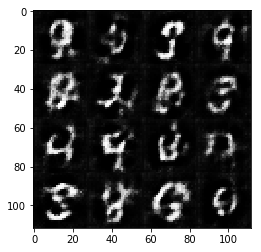

Epoch 1/2... Discriminator Loss: 1.033511... Generator Loss: 1.0414
Epoch 1/2... Discriminator Loss: 1.206118... Generator Loss: 2.2357
Epoch 1/2... Discriminator Loss: 1.344096... Generator Loss: 2.8620
Epoch 1/2... Discriminator Loss: 1.113486... Generator Loss: 2.3720
Epoch 1/2... Discriminator Loss: 0.938518... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 1.212678... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.645626... Generator Loss: 2.7236
Epoch 1/2... Discriminator Loss: 1.157060... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 1.078138... Generator Loss: 1.6817
Epoch 1/2... Discriminator Loss: 1.444687... Generator Loss: 0.4629


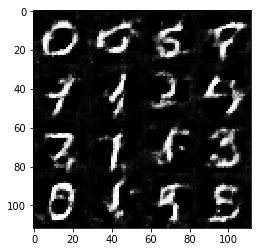

Epoch 1/2... Discriminator Loss: 0.971084... Generator Loss: 0.9818
Epoch 1/2... Discriminator Loss: 1.096162... Generator Loss: 1.2419
Epoch 1/2... Discriminator Loss: 1.462313... Generator Loss: 0.4486
Epoch 1/2... Discriminator Loss: 1.222631... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 1.000543... Generator Loss: 1.2900
Epoch 1/2... Discriminator Loss: 1.215703... Generator Loss: 1.6683
Epoch 1/2... Discriminator Loss: 0.972601... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 1.053085... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 0.950540... Generator Loss: 1.0225
Epoch 1/2... Discriminator Loss: 1.270881... Generator Loss: 0.6447


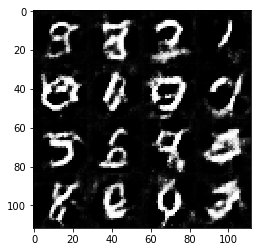

Epoch 1/2... Discriminator Loss: 1.029293... Generator Loss: 1.4504
Epoch 1/2... Discriminator Loss: 1.038898... Generator Loss: 1.5998
Epoch 1/2... Discriminator Loss: 0.942768... Generator Loss: 1.7243
Epoch 1/2... Discriminator Loss: 0.923091... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 0.974881... Generator Loss: 1.4376
Epoch 1/2... Discriminator Loss: 1.016653... Generator Loss: 1.1482
Epoch 1/2... Discriminator Loss: 1.159936... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.039745... Generator Loss: 1.3539
Epoch 1/2... Discriminator Loss: 0.944632... Generator Loss: 1.5826
Epoch 1/2... Discriminator Loss: 1.716164... Generator Loss: 0.4428


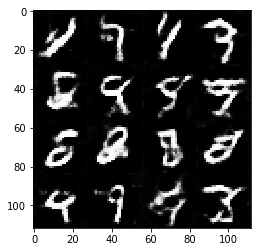

Epoch 1/2... Discriminator Loss: 0.911692... Generator Loss: 1.0566
Epoch 1/2... Discriminator Loss: 1.281033... Generator Loss: 2.4935
Epoch 1/2... Discriminator Loss: 0.915570... Generator Loss: 1.8756
Epoch 1/2... Discriminator Loss: 1.072184... Generator Loss: 1.9950
Epoch 1/2... Discriminator Loss: 1.010844... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 0.903515... Generator Loss: 1.0804
Epoch 1/2... Discriminator Loss: 0.994814... Generator Loss: 1.7181
Epoch 1/2... Discriminator Loss: 2.875893... Generator Loss: 0.1854
Epoch 1/2... Discriminator Loss: 0.930882... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 1.010151... Generator Loss: 1.0340


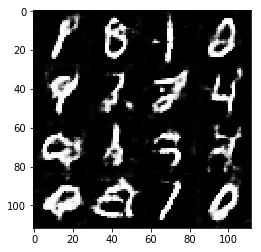

Epoch 1/2... Discriminator Loss: 1.018856... Generator Loss: 1.7682
Epoch 1/2... Discriminator Loss: 1.058659... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 0.882663... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 1.605435... Generator Loss: 0.4072
Epoch 1/2... Discriminator Loss: 0.890421... Generator Loss: 1.2044
Epoch 1/2... Discriminator Loss: 1.293244... Generator Loss: 1.8483
Epoch 1/2... Discriminator Loss: 0.920780... Generator Loss: 1.2290
Epoch 1/2... Discriminator Loss: 1.234417... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.069956... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 0.997698... Generator Loss: 1.3178


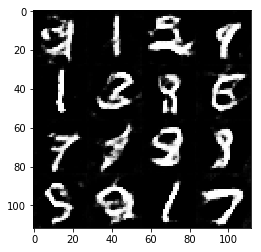

Epoch 1/2... Discriminator Loss: 0.977814... Generator Loss: 1.3063
Epoch 1/2... Discriminator Loss: 1.023113... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.239970... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.105994... Generator Loss: 2.1097
Epoch 1/2... Discriminator Loss: 0.937393... Generator Loss: 1.0552
Epoch 1/2... Discriminator Loss: 1.119202... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.134911... Generator Loss: 0.7041
Epoch 1/2... Discriminator Loss: 5.342932... Generator Loss: 6.6909
Epoch 1/2... Discriminator Loss: 1.694241... Generator Loss: 0.4159
Epoch 1/2... Discriminator Loss: 0.926093... Generator Loss: 0.9934


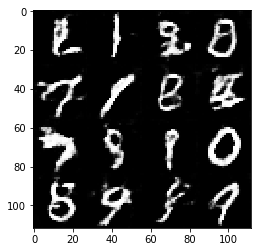

Epoch 1/2... Discriminator Loss: 0.883494... Generator Loss: 1.6158
Epoch 1/2... Discriminator Loss: 1.227284... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 0.762692... Generator Loss: 1.5678
Epoch 1/2... Discriminator Loss: 0.797988... Generator Loss: 1.3064
Epoch 1/2... Discriminator Loss: 1.291310... Generator Loss: 3.3846
Epoch 1/2... Discriminator Loss: 0.925127... Generator Loss: 0.9500
Epoch 1/2... Discriminator Loss: 1.179285... Generator Loss: 3.1601
Epoch 1/2... Discriminator Loss: 0.870876... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 0.848309... Generator Loss: 1.1502
Epoch 1/2... Discriminator Loss: 0.819252... Generator Loss: 1.1865


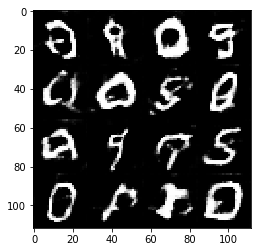

Epoch 1/2... Discriminator Loss: 1.028483... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 0.985157... Generator Loss: 0.8974
Epoch 1/2... Discriminator Loss: 0.905546... Generator Loss: 0.9972
Epoch 2/2... Discriminator Loss: 0.598231... Generator Loss: 1.9923
Epoch 2/2... Discriminator Loss: 1.256283... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 0.858799... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.787107... Generator Loss: 1.3823
Epoch 2/2... Discriminator Loss: 1.263613... Generator Loss: 0.6414
Epoch 2/2... Discriminator Loss: 0.971308... Generator Loss: 1.3257
Epoch 2/2... Discriminator Loss: 0.906860... Generator Loss: 2.0353


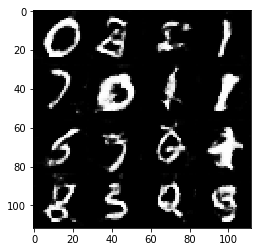

Epoch 2/2... Discriminator Loss: 0.975486... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 0.744128... Generator Loss: 1.5803
Epoch 2/2... Discriminator Loss: 0.872417... Generator Loss: 1.1136
Epoch 2/2... Discriminator Loss: 0.939712... Generator Loss: 1.0227
Epoch 2/2... Discriminator Loss: 0.725611... Generator Loss: 1.4562
Epoch 2/2... Discriminator Loss: 0.751717... Generator Loss: 2.0300
Epoch 2/2... Discriminator Loss: 1.127107... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 1.026210... Generator Loss: 0.8935
Epoch 2/2... Discriminator Loss: 0.773630... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 1.041283... Generator Loss: 1.4793


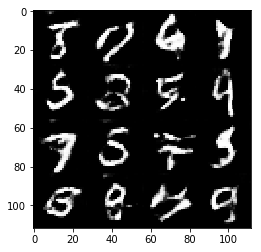

Epoch 2/2... Discriminator Loss: 0.910512... Generator Loss: 1.5135
Epoch 2/2... Discriminator Loss: 1.079817... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 1.222015... Generator Loss: 2.8175
Epoch 2/2... Discriminator Loss: 0.955150... Generator Loss: 0.9346
Epoch 2/2... Discriminator Loss: 0.696467... Generator Loss: 1.4317
Epoch 2/2... Discriminator Loss: 1.268633... Generator Loss: 0.6217
Epoch 2/2... Discriminator Loss: 1.058824... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 0.818221... Generator Loss: 1.1466
Epoch 2/2... Discriminator Loss: 1.021665... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 0.989297... Generator Loss: 0.9465


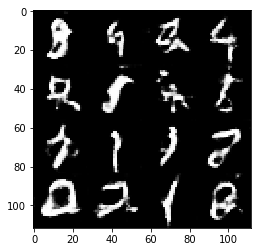

Epoch 2/2... Discriminator Loss: 1.573708... Generator Loss: 3.9024
Epoch 2/2... Discriminator Loss: 0.914878... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 0.794027... Generator Loss: 1.9540
Epoch 2/2... Discriminator Loss: 0.811298... Generator Loss: 1.4192
Epoch 2/2... Discriminator Loss: 0.733842... Generator Loss: 1.4160
Epoch 2/2... Discriminator Loss: 0.870476... Generator Loss: 1.2758
Epoch 2/2... Discriminator Loss: 0.902544... Generator Loss: 1.1782
Epoch 2/2... Discriminator Loss: 0.916026... Generator Loss: 1.0111
Epoch 2/2... Discriminator Loss: 0.816474... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.986237... Generator Loss: 0.9378


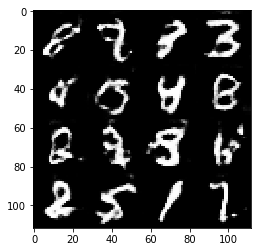

Epoch 2/2... Discriminator Loss: 0.737656... Generator Loss: 1.3233
Epoch 2/2... Discriminator Loss: 0.786342... Generator Loss: 1.2752
Epoch 2/2... Discriminator Loss: 1.296018... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 0.619992... Generator Loss: 1.6957
Epoch 2/2... Discriminator Loss: 0.838804... Generator Loss: 1.1166
Epoch 2/2... Discriminator Loss: 0.679964... Generator Loss: 1.6456
Epoch 2/2... Discriminator Loss: 0.743764... Generator Loss: 1.4245
Epoch 2/2... Discriminator Loss: 0.950518... Generator Loss: 1.2992
Epoch 2/2... Discriminator Loss: 0.777122... Generator Loss: 1.7027
Epoch 2/2... Discriminator Loss: 0.698687... Generator Loss: 1.4190


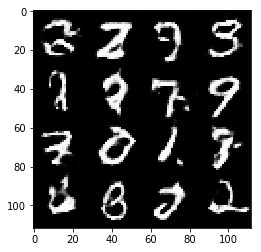

Epoch 2/2... Discriminator Loss: 0.808064... Generator Loss: 1.2544
Epoch 2/2... Discriminator Loss: 0.973381... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 0.789837... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 1.048959... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 0.857295... Generator Loss: 1.2148
Epoch 2/2... Discriminator Loss: 0.908121... Generator Loss: 1.1594
Epoch 2/2... Discriminator Loss: 1.276382... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.073959... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 0.824390... Generator Loss: 1.3371
Epoch 2/2... Discriminator Loss: 0.777352... Generator Loss: 1.3593


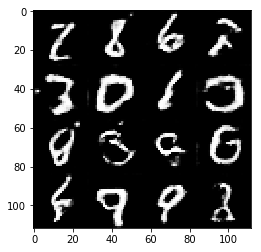

Epoch 2/2... Discriminator Loss: 0.849124... Generator Loss: 1.3034
Epoch 2/2... Discriminator Loss: 0.796910... Generator Loss: 2.6839
Epoch 2/2... Discriminator Loss: 0.796100... Generator Loss: 1.2214
Epoch 2/2... Discriminator Loss: 1.165757... Generator Loss: 0.8128
Epoch 2/2... Discriminator Loss: 0.779640... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 0.659947... Generator Loss: 1.4923
Epoch 2/2... Discriminator Loss: 0.850714... Generator Loss: 1.2149
Epoch 2/2... Discriminator Loss: 1.088829... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 0.955592... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 0.856005... Generator Loss: 1.1383


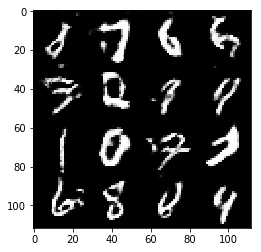

Epoch 2/2... Discriminator Loss: 0.677960... Generator Loss: 1.4825
Epoch 2/2... Discriminator Loss: 1.122411... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 0.864790... Generator Loss: 1.1605
Epoch 2/2... Discriminator Loss: 1.504624... Generator Loss: 0.5630
Epoch 2/2... Discriminator Loss: 0.964778... Generator Loss: 1.6885
Epoch 2/2... Discriminator Loss: 0.692171... Generator Loss: 1.5209
Epoch 2/2... Discriminator Loss: 0.864086... Generator Loss: 1.0742
Epoch 2/2... Discriminator Loss: 0.700306... Generator Loss: 1.7527
Epoch 2/2... Discriminator Loss: 0.730872... Generator Loss: 1.3761
Epoch 2/2... Discriminator Loss: 0.939925... Generator Loss: 0.9625


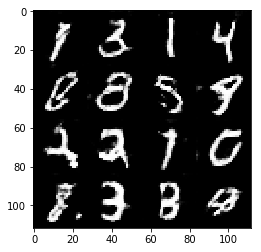

Epoch 2/2... Discriminator Loss: 0.651332... Generator Loss: 1.5600
Epoch 2/2... Discriminator Loss: 0.741524... Generator Loss: 1.3861
Epoch 2/2... Discriminator Loss: 2.487623... Generator Loss: 4.8159
Epoch 2/2... Discriminator Loss: 1.639838... Generator Loss: 0.4726
Epoch 2/2... Discriminator Loss: 0.693019... Generator Loss: 1.6169
Epoch 2/2... Discriminator Loss: 1.099590... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 0.727937... Generator Loss: 2.3273
Epoch 2/2... Discriminator Loss: 1.193835... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 1.326038... Generator Loss: 0.6669
Epoch 2/2... Discriminator Loss: 1.016385... Generator Loss: 0.8835


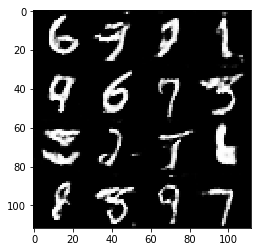

Epoch 2/2... Discriminator Loss: 0.701917... Generator Loss: 1.4386
Epoch 2/2... Discriminator Loss: 0.857239... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 1.412958... Generator Loss: 0.6336
Epoch 2/2... Discriminator Loss: 0.939597... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 0.666231... Generator Loss: 2.1745
Epoch 2/2... Discriminator Loss: 0.722414... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 0.899476... Generator Loss: 1.0727


In [20]:
batch_size = 64
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.490315... Generator Loss: 0.0607
Epoch 1/1... Discriminator Loss: 0.632703... Generator Loss: 8.3404
Epoch 1/1... Discriminator Loss: 1.016120... Generator Loss: 2.8264
Epoch 1/1... Discriminator Loss: 2.491785... Generator Loss: 0.2350
Epoch 1/1... Discriminator Loss: 0.880705... Generator Loss: 2.1951
Epoch 1/1... Discriminator Loss: 1.014743... Generator Loss: 1.9904
Epoch 1/1... Discriminator Loss: 1.249782... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.336942... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.052933... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.789953... Generator Loss: 0.3380


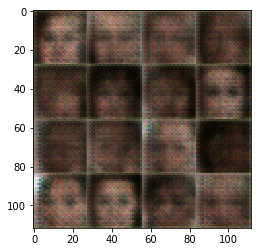

Epoch 1/1... Discriminator Loss: 1.286125... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.923258... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 1.631117... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.747709... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 2.168963... Generator Loss: 0.2017
Epoch 1/1... Discriminator Loss: 1.396140... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.230473... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 0.858298... Generator Loss: 1.6336
Epoch 1/1... Discriminator Loss: 0.724920... Generator Loss: 3.6820
Epoch 1/1... Discriminator Loss: 3.245725... Generator Loss: 5.0248


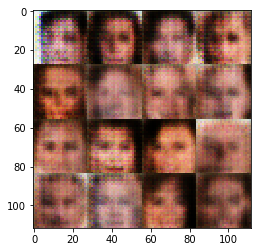

Epoch 1/1... Discriminator Loss: 1.275576... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.167149... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.129103... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.367610... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.030769... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 0.687638... Generator Loss: 1.5807
Epoch 1/1... Discriminator Loss: 1.090633... Generator Loss: 1.1127
Epoch 1/1... Discriminator Loss: 1.863314... Generator Loss: 0.2944
Epoch 1/1... Discriminator Loss: 0.348562... Generator Loss: 5.6320
Epoch 1/1... Discriminator Loss: 0.917514... Generator Loss: 1.2016


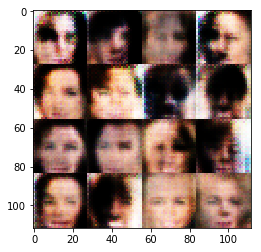

Epoch 1/1... Discriminator Loss: 1.073669... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 0.402410... Generator Loss: 3.0932
Epoch 1/1... Discriminator Loss: 1.517185... Generator Loss: 4.7939
Epoch 1/1... Discriminator Loss: 1.248290... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 0.579796... Generator Loss: 2.2881
Epoch 1/1... Discriminator Loss: 1.820120... Generator Loss: 0.3422
Epoch 1/1... Discriminator Loss: 1.392375... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.174420... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 0.941824... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.515242... Generator Loss: 0.6523


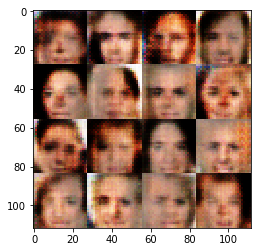

Epoch 1/1... Discriminator Loss: 1.199298... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 0.882282... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.011143... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 0.843533... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 3.306006... Generator Loss: 0.0614
Epoch 1/1... Discriminator Loss: 1.356619... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.027051... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.096446... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.155721... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 0.882522... Generator Loss: 1.3123


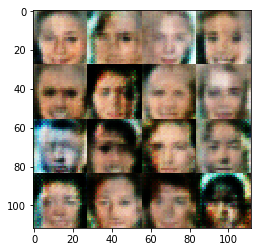

Epoch 1/1... Discriminator Loss: 1.498206... Generator Loss: 0.4119
Epoch 1/1... Discriminator Loss: 0.897011... Generator Loss: 1.6623
Epoch 1/1... Discriminator Loss: 1.747601... Generator Loss: 0.3130
Epoch 1/1... Discriminator Loss: 1.525880... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 0.468004... Generator Loss: 3.6405
Epoch 1/1... Discriminator Loss: 1.565228... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 1.437087... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 1.630496... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 0.839608... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.145454... Generator Loss: 0.7311


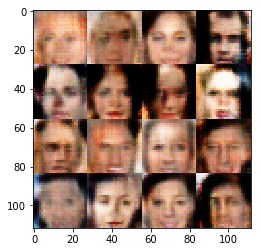

Epoch 1/1... Discriminator Loss: 1.381916... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 0.735694... Generator Loss: 4.0250
Epoch 1/1... Discriminator Loss: 1.118163... Generator Loss: 1.9345
Epoch 1/1... Discriminator Loss: 0.601798... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 1.751733... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.243133... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.287892... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.286222... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.313460... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.066109... Generator Loss: 2.0246


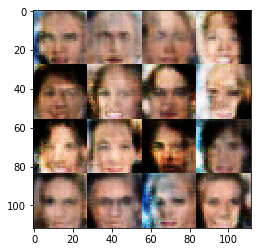

Epoch 1/1... Discriminator Loss: 1.285665... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 1.271155... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 2.670886... Generator Loss: 3.3596
Epoch 1/1... Discriminator Loss: 1.202983... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.145196... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.564307... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 0.846514... Generator Loss: 4.9578
Epoch 1/1... Discriminator Loss: 1.160548... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.316556... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.071031... Generator Loss: 0.9266


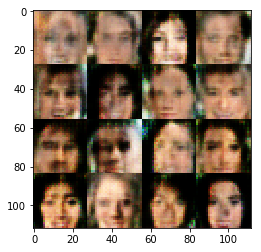

Epoch 1/1... Discriminator Loss: 1.443437... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 0.509188... Generator Loss: 2.0527
Epoch 1/1... Discriminator Loss: 3.596542... Generator Loss: 4.4493
Epoch 1/1... Discriminator Loss: 1.232888... Generator Loss: 1.4787
Epoch 1/1... Discriminator Loss: 0.634372... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 0.999955... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.380448... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 0.618883... Generator Loss: 2.6511
Epoch 1/1... Discriminator Loss: 0.970079... Generator Loss: 1.0781
Epoch 1/1... Discriminator Loss: 1.626477... Generator Loss: 0.3570


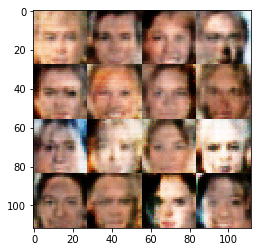

Epoch 1/1... Discriminator Loss: 1.526555... Generator Loss: 3.3400
Epoch 1/1... Discriminator Loss: 0.863137... Generator Loss: 1.9821
Epoch 1/1... Discriminator Loss: 1.312601... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.311711... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.170088... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.122129... Generator Loss: 1.1937
Epoch 1/1... Discriminator Loss: 0.664669... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 0.700221... Generator Loss: 1.3261
Epoch 1/1... Discriminator Loss: 1.753654... Generator Loss: 0.3302
Epoch 1/1... Discriminator Loss: 1.821062... Generator Loss: 1.5328


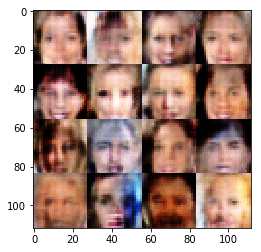

Epoch 1/1... Discriminator Loss: 1.070904... Generator Loss: 2.5937
Epoch 1/1... Discriminator Loss: 1.166024... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.358867... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 0.675455... Generator Loss: 1.8803
Epoch 1/1... Discriminator Loss: 0.558117... Generator Loss: 1.7743
Epoch 1/1... Discriminator Loss: 0.857891... Generator Loss: 2.0126
Epoch 1/1... Discriminator Loss: 1.610164... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 0.618524... Generator Loss: 3.4445
Epoch 1/1... Discriminator Loss: 0.840471... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 0.672790... Generator Loss: 1.5050


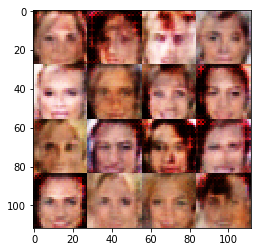

Epoch 1/1... Discriminator Loss: 1.228402... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 1.149240... Generator Loss: 3.2629
Epoch 1/1... Discriminator Loss: 1.042310... Generator Loss: 2.6623
Epoch 1/1... Discriminator Loss: 1.373508... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.055464... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 1.199925... Generator Loss: 3.2770
Epoch 1/1... Discriminator Loss: 0.739334... Generator Loss: 3.4714
Epoch 1/1... Discriminator Loss: 1.075763... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.555213... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 1.248604... Generator Loss: 0.5848


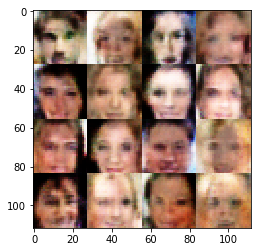

Epoch 1/1... Discriminator Loss: 0.679421... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 0.971039... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 1.051369... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.507152... Generator Loss: 1.5862
Epoch 1/1... Discriminator Loss: 1.544557... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 0.878996... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 0.933409... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.627333... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 0.415695... Generator Loss: 4.1091
Epoch 1/1... Discriminator Loss: 0.962772... Generator Loss: 0.8857


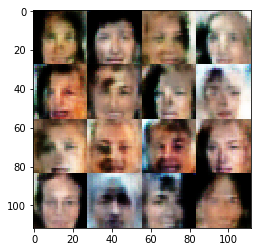

Epoch 1/1... Discriminator Loss: 1.121871... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.744944... Generator Loss: 2.0210
Epoch 1/1... Discriminator Loss: 1.390929... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.187110... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.195428... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.064739... Generator Loss: 1.6354
Epoch 1/1... Discriminator Loss: 0.483740... Generator Loss: 2.3938
Epoch 1/1... Discriminator Loss: 1.131677... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.395985... Generator Loss: 2.9402
Epoch 1/1... Discriminator Loss: 0.870934... Generator Loss: 1.8432


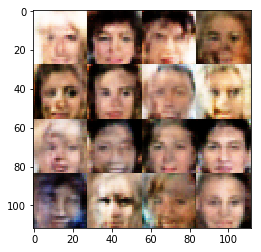

Epoch 1/1... Discriminator Loss: 1.890164... Generator Loss: 2.4202
Epoch 1/1... Discriminator Loss: 1.138790... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 1.261443... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.115256... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.891078... Generator Loss: 2.1970
Epoch 1/1... Discriminator Loss: 1.171840... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.161498... Generator Loss: 1.3996
Epoch 1/1... Discriminator Loss: 1.295407... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 0.930238... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.046940... Generator Loss: 1.3831


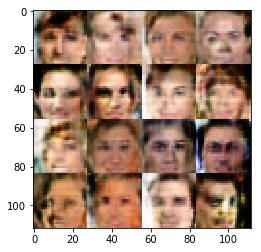

Epoch 1/1... Discriminator Loss: 1.377987... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.257604... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 0.664178... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 1.166523... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.373536... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 0.794405... Generator Loss: 2.1028
Epoch 1/1... Discriminator Loss: 1.312496... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.260718... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.167130... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.383686... Generator Loss: 1.6982


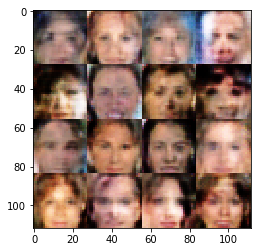

Epoch 1/1... Discriminator Loss: 1.228663... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.842657... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.071433... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.435353... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 0.982730... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.626671... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 0.682390... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 1.078272... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.116240... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.279812... Generator Loss: 0.5791


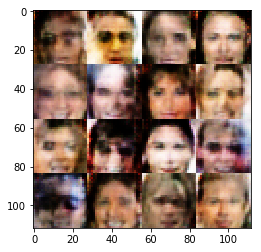

Epoch 1/1... Discriminator Loss: 1.377867... Generator Loss: 2.8799
Epoch 1/1... Discriminator Loss: 1.304087... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.377270... Generator Loss: 2.4015
Epoch 1/1... Discriminator Loss: 0.556145... Generator Loss: 2.2536
Epoch 1/1... Discriminator Loss: 1.111098... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 0.539630... Generator Loss: 1.9926
Epoch 1/1... Discriminator Loss: 1.228739... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.122436... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.205870... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.302987... Generator Loss: 0.9050


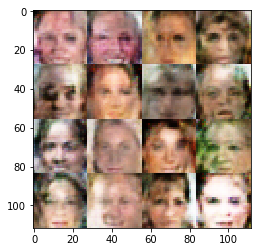

Epoch 1/1... Discriminator Loss: 1.147591... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.660440... Generator Loss: 2.8660
Epoch 1/1... Discriminator Loss: 0.544074... Generator Loss: 2.3470
Epoch 1/1... Discriminator Loss: 1.559642... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.373138... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.432829... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 0.888375... Generator Loss: 1.6854
Epoch 1/1... Discriminator Loss: 0.927159... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 1.261325... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.141896... Generator Loss: 1.2457


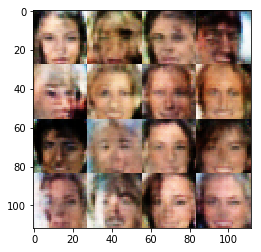

Epoch 1/1... Discriminator Loss: 1.491658... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 1.537156... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.370852... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.024101... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 0.973105... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.701368... Generator Loss: 1.8219
Epoch 1/1... Discriminator Loss: 1.188160... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.417583... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.619473... Generator Loss: 3.0069
Epoch 1/1... Discriminator Loss: 1.054045... Generator Loss: 1.0909


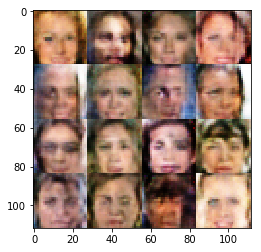

Epoch 1/1... Discriminator Loss: 1.103745... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 0.597256... Generator Loss: 1.9582
Epoch 1/1... Discriminator Loss: 1.541098... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 0.896106... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.240199... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.852990... Generator Loss: 1.8712
Epoch 1/1... Discriminator Loss: 1.217781... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 0.799798... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 1.547418... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.426849... Generator Loss: 0.5513


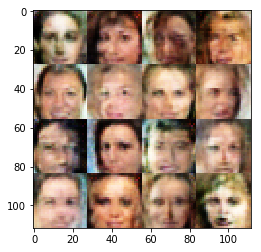

Epoch 1/1... Discriminator Loss: 1.362607... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.392023... Generator Loss: 0.5062
Epoch 1/1... Discriminator Loss: 1.260903... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.248291... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 1.417537... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.178528... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.289951... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.410345... Generator Loss: 1.3716
Epoch 1/1... Discriminator Loss: 1.344372... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.370270... Generator Loss: 0.6418


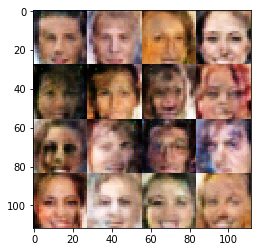

Epoch 1/1... Discriminator Loss: 1.754716... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 0.965375... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 0.879109... Generator Loss: 1.5623
Epoch 1/1... Discriminator Loss: 1.029340... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.955201... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 0.836796... Generator Loss: 1.7744
Epoch 1/1... Discriminator Loss: 0.991967... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.289090... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.158451... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.057904... Generator Loss: 1.1365


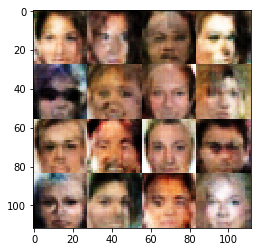

Epoch 1/1... Discriminator Loss: 1.259635... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.364409... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.292290... Generator Loss: 0.9737
Epoch 1/1... Discriminator Loss: 1.143759... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.196575... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 0.893126... Generator Loss: 2.1549
Epoch 1/1... Discriminator Loss: 1.586268... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 0.927716... Generator Loss: 1.1997
Epoch 1/1... Discriminator Loss: 0.809020... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 3.028632... Generator Loss: 2.6419


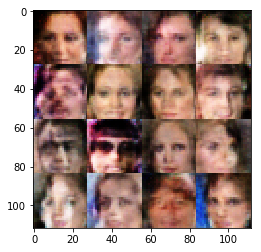

Epoch 1/1... Discriminator Loss: 1.156543... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.541142... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.274025... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.763611... Generator Loss: 1.6984
Epoch 1/1... Discriminator Loss: 1.340433... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.315937... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.484518... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.197855... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.204968... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.290671... Generator Loss: 0.8423


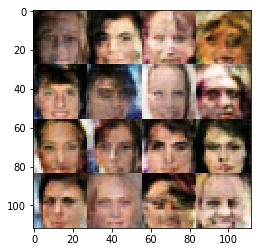

Epoch 1/1... Discriminator Loss: 1.340873... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.240314... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.274366... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.232458... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.437675... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.427371... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.465063... Generator Loss: 1.5648
Epoch 1/1... Discriminator Loss: 1.581879... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 0.953723... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.007599... Generator Loss: 1.0155


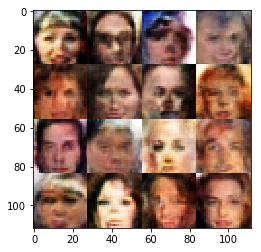

Epoch 1/1... Discriminator Loss: 1.051333... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.201760... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 1.098581... Generator Loss: 1.2410
Epoch 1/1... Discriminator Loss: 0.777347... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 1.655585... Generator Loss: 3.1000
Epoch 1/1... Discriminator Loss: 1.004525... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.292634... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.141367... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.123512... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.234351... Generator Loss: 0.8671


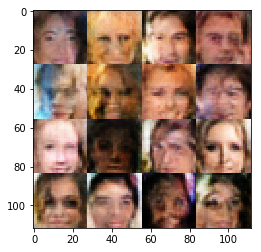

Epoch 1/1... Discriminator Loss: 1.266950... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.122880... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.272429... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.215738... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.383918... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 1.041478... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.109101... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.188323... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.270154... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.302739... Generator Loss: 0.8234


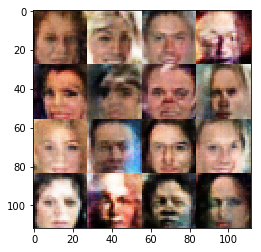

Epoch 1/1... Discriminator Loss: 1.274929... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.197982... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.213091... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.182997... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.306226... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.519666... Generator Loss: 1.7314
Epoch 1/1... Discriminator Loss: 1.273202... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.395143... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.202005... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.131186... Generator Loss: 0.7277


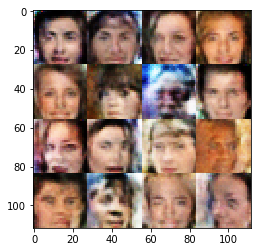

Epoch 1/1... Discriminator Loss: 1.411910... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.066045... Generator Loss: 1.6973
Epoch 1/1... Discriminator Loss: 1.306994... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.117846... Generator Loss: 1.7565
Epoch 1/1... Discriminator Loss: 1.121251... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.173461... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.186521... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.210502... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.158063... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.251391... Generator Loss: 0.6492


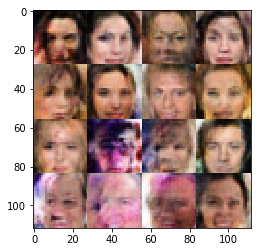

Epoch 1/1... Discriminator Loss: 0.772106... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 1.044120... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.251563... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.167698... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.204330... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.523274... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 1.270006... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.187321... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.533906... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.249188... Generator Loss: 0.8222


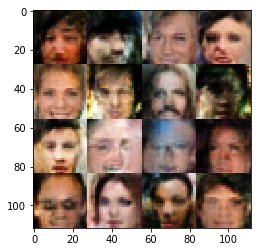

Epoch 1/1... Discriminator Loss: 1.181085... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.882261... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.350239... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 2.327318... Generator Loss: 0.1791
Epoch 1/1... Discriminator Loss: 0.914937... Generator Loss: 1.5840
Epoch 1/1... Discriminator Loss: 1.250447... Generator Loss: 0.7192


In [22]:
batch_size = 64
z_dim = 128
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.